In [2]:
import tensorflow as tf

print("tf version is ",tf.__version__)

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../lib/")
from pathlib import Path


2023-06-28 10:22:09.401194: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 10:22:10.011481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 10:22:10.012603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 10:22:12.902974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tf version is  2.13.0-dev20230411


In [7]:
#dataset = "L_540_2022_C_E_R_B"
dataset = "L_540_2022_C_E_R_B"

results_path = Path("../results/") / dataset
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))
if "file" in data.columns:
    X = data.drop(columns=["label", "file"])    
else:
    X = data.drop(columns=[""])

wns = np.asarray(X.columns.astype(float))

X = np.asarray(X)
y = np.asarray(data.label)
y, y_key = pd.factorize(y) # not important but nice for enumerate below
y_one_hot = label_binarize(y, classes=np.unique(y))  # Perform one-hot encoding on the labels
y_one_hot = y_one_hot.ravel()                           
for i, label in enumerate(y_key):
    print(f"{label}: {i}")
y_one_hot.shape
wns

Both: 0
Control: 1
Etoposide: 2
Resveratrol: 3


array([ 450. ,  450.5,  451. , ..., 1749. , 1749.5, 1750. ])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [1200, 4800]

In [13]:
rate = 0.3
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(rate),
    Dense(1, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), 
                    batch_size=32, verbose=False, use_multiprocessing = True,
                    callbacks = [tf.keras.callbacks.EarlyStopping(patience=50)])

/home/fhwn.ac.at/106374/.local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


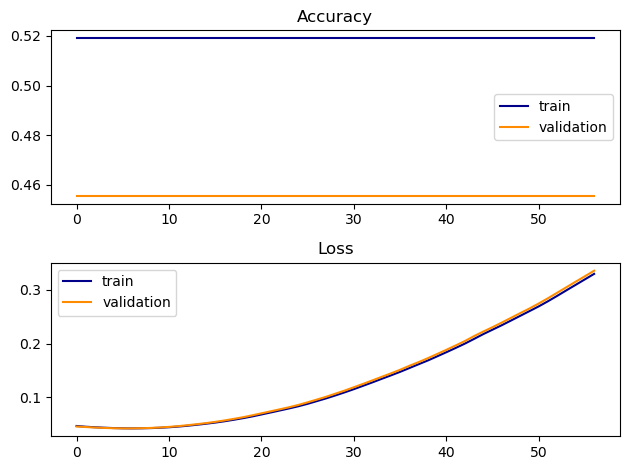

In [23]:
plt.subplot(2,1,1)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], color="darkblue", label="train")
plt.plot(history.history["val_accuracy"], color="darkorange", label="validation")
plt.legend(loc="best")

plt.subplot(2,1,2)
plt.title("Loss")
plt.plot(history.history["loss"], color="darkblue", label="train")
plt.plot(history.history["val_loss"], color="darkorange", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [15]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the number of cross-validation splits
n_splits = 5
n_repeats = 20

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X, y_one_hot, cv=cv, scoring='accuracy', n_jobs=-1)

# Print the average accuracy and standard deviation
print('Average Accuracy:', scores.mean())
print('Standard Deviation:', scores.std())

TypeError: Cannot clone object '<keras.src.engine.sequential.Sequential object at 0x7f99340e8cd0>' (type <class 'keras.src.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [101]:
y_pred = []
predictions = model.predict(X_test)  # Predict probabilities for all test samples
for prediction in predictions:
    y_hot_encoded = np.zeros_like(prediction)
    y_hot_encoded[np.argmax(prediction)] = 1
    y_pred.append(y_hot_encoded)
print("Model testing finished")

12/12 [==============================] - 0s 2ms/step
Model testing finished


In [102]:
# Convert one-hot encoded predictions to class indices
y_pred = np.argmax(y_pred, axis=1)
# Convert one-hot encoded true labels to class indices
y_test = np.argmax(y_test, axis=1)


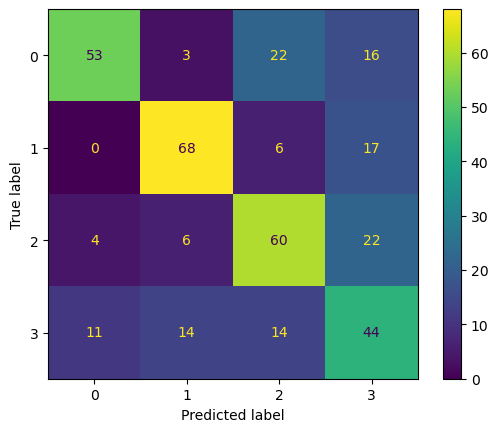

              precision    recall  f1-score   support

           0       0.78      0.56      0.65        94
           1       0.75      0.75      0.75        91
           2       0.59      0.65      0.62        92
           3       0.44      0.53      0.48        83

    accuracy                           0.62       360
   macro avg       0.64      0.62      0.63       360
weighted avg       0.65      0.62      0.63       360



In [107]:
# Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred) # Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

acc = accuracy_score(y_pred,y_test) # accuracy
print(classification_report(y_test,y_pred)) # Precision/Recall/F1-Score

## Calculate precision, recall, and thresholds

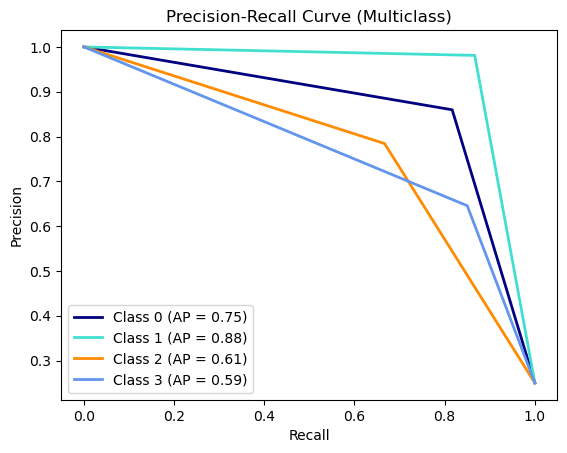

In [65]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
# Convert y_test and y_pred to one-hot encoded format
y_test_binary = label_binarize(y_test, classes=np.unique(y_test))
y_pred_binary = label_binarize(y_pred, classes=np.unique(y_test))

# Calculate precision, recall, and average precision scores for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(y_key)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binary[:, i], y_pred_binary[:, i])
    average_precision[i] = average_precision_score(y_test_binary[:, i], y_pred_binary[:, i])

# Plot the precision-recall curves for each class
plt.figure()
colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len(y_key)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label='Class {0} (AP = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Multiclass)')
plt.legend(loc='best')
plt.show()


In [98]:
# Evaluate the model on the test set

model.evaluate(X_test, y_test, verbose=2)

12/12 - 0s - loss: 1.2641 - accuracy: 0.6250 - 123ms/epoch - 10ms/step


[1.2641054391860962, 0.625]

In [96]:
# Continue with model training using the augmented data
model.fit(X_train_augmented, y_train_augmented, epochs=30, validation_data=(X_test, y_test), verbose = False, use_multiprocessing = True,
)

NameError: name 'X_train_augmented' is not defined

In [97]:
# Define the augmentation parameters
num_augmentations = 20 #Number of augmented spectra to generate
shift_range = (-10, 10)  # Range for shifting the wavenumbers
intensity_factor_range = .2)  # Range for scaling the intensities
noise_std = 0.05  # Standard deviation for adding random Gaussian noise

# Augment the spectral data
augmented_X_train = []
augmented_y_train = []

for spectrum, label in zip(X_train, y_train):
    for _ in range(num_augmentations):
        # Shift the wavenumbers
        shift_amount = np.random.uniform(*shift_range)
        shifted_spectrum = np.roll(spectrum, int(shift_amount))

        # Scale the intensities
        intensity_factor = np.random.uniform(*intensity_factor_range)
        scaled_spectrum = shifted_spectrum * intensity_factor

        # Add random Gaussian noise to the intensities
        noisy_spectrum = scaled_spectrum + np.random.normal(0, noise_std, spectrum.shape)

        augmented_X_train.append(noisy_spectrum)
        augmented_y_train.append(label)

# Convert the augmented data to numpy arrays
augmented_X_train = np.array(augmented_X_train)
augmented_y_train = np.array(augmented_y_train)

# Combine the augmented data with the original data
combined_X_train = np.concatenate((X_train, augmented_X_train), axis=0)
combined_y_train = np.concatenate((y_train, augmented_y_train), axis=0)

# Shuffle the data
indices = np.arange(combined_X_train.shape[0])
np.random.shuffle(indices)
combined_X_train = combined_X_train[indices]
combined_y_train = combined_y_train[indices]

# Convert the augmented data to numpy arrays
augmented_X_train = np.array(combined_X_train)
augmented_y_train = np.array(combined_y_train)

# Concatenate the augmented data with the original data
X_train_augmented = np.concatenate((X_train, augmented_X_train), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_y_train), axis=0)

KeyboardInterrupt: 

In [93]:
%%bash 
pwd

/proj/raman/Posch_Masterarbeit/Multiclass_RamanMachineLearning/notebooks
